In [1]:
from nes_py.wrappers import BinarySpaceToDiscreteSpaceEnv, PenalizeDeathEnv
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT, RIGHT_ONLY
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = BinarySpaceToDiscreteSpaceEnv(env, RIGHT_ONLY)

#env = PenalizeDeathEnv(env, COMPLEX_MOVEMENT)

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam,SGD

Using TensorFlow backend.


In [3]:
# Conv 
input_img = (240,256,3)

def cnn_q(input_img):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(8,8), strides=4 ,input_shape=input_img, activation='relu'))
    model.add(Conv2D(64, (4,4), strides=2, activation='relu'))
    model.add(Conv2D(64, (3,3),  strides=1, activation='relu'))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dense(4,activation='linear'))
    return model
    

optimizer = Adam(lr = 1e-4)
model = cnn_q(input_img)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 59, 63, 32)        6176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 30, 64)        32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 28, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 46592)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               11927808  
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 12,004,772
Trainable params: 12,004,772
Non-trainable params: 0
________________________________________________________________

In [4]:
from collections import deque
import random
from tqdm import tqdm
import numpy as np
import copy

discount = 0.9

RIGHT_ONLY = RIGHT_ONLY[1:]

env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = BinarySpaceToDiscreteSpaceEnv(env, RIGHT_ONLY)

def create_y(states, actions, rewards, next_states, terminals):
    Q = model.predict(states)
    TQ = np.where(terminals, rewards, rewards + discount*np.max(model.predict(next_states).reshape(-1,4),axis=1))
    Q[:,actions] = TQ
    return Q

capacity = 500
horizon, num_episodes = 500, 10
eps = 1.0
decay = 8/10000
bsize = 2
D = deque(maxlen = capacity)

states_r, actions_r, rewards_r, next_states_r, terminals_r = (np.zeros((horizon, 240, 256,3)),
                                                              np.zeros((horizon), dtype=int),
                                                              np.zeros((horizon)),
                                                              np.zeros((horizon, 240, 256,3)),
                                                              np.zeros((horizon)))

for episode in tqdm(range(num_episodes)):
    state = env.reset()
    for t in range(horizon):
        bern = np.random.binomial(1, eps)
        action = bern*np.random.randint(4) + (1-bern)*np.argmax(model.predict(state.reshape(1,240,256,3)))
        next_state, reward, terminal, info = env.step(action)
        env.render()
        states_r[t], actions_r[t], rewards_r[t], next_states_r[t], terminals_r[t] = [state, action,
                                                                                     reward, next_state, terminal]
        #D.append([state, action, reward, next_state, terminal])
        state = copy.copy(next_state)
        if terminal : state = env.reset()
            
        if episode != 0 : minibatch = np.random.choice(np.arange(horizon), bsize)
        else : minibatch = np.random.choice(np.arange(t+1), min(bsize, t+1))
        
        data, y = states_r[minibatch], create_y(states_r[minibatch], actions_r[minibatch], rewards_r[minibatch],
                                              next_states_r[minibatch], terminals_r[minibatch])
        model.train_on_batch(data, y)
        eps = max(0.2, eps - decay)
env.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:26<00:00, 49.29s/it]


In [6]:
env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = BinarySpaceToDiscreteSpaceEnv(env, RIGHT_ONLY)
done = True
for step in range(5000):
    if done:
        state = env.reset()
    action = np.argmax(model.predict(state.reshape(1,240,256,3)))
    state, reward, done, info = env.step(action)
#     if done : 
#         h = state
#         print(reward)
#         print(done)
    env.render()

env.close()

In [5]:
discount = 0.9
for t in range(50): 
    path = collect_episodes(env, model, horizon=200)[0]
    Q = model.predict(path['states'])
    TQ = path['rewards'] + discount*np.max(model.predict(path['next_states']),axis=1)
    Q[:,path['actions']] = TQ
    model.fit(path['states'], Q, verbose=0)
    if (t+1)%50 == 0 : 
        print('iteration {}'.format(t))
    

iteration 49


In [ ]:
env = gym_super_mario_bros.make('SuperMarioBrosNoFrameskip-v0')
env = BinarySpaceToDiscreteSpaceEnv(env, RIGHT_ONLY)
done = True
for step in range(500):
    if done:
        state = env.reset()
    action = np.argmax(model.predict(state.reshape(1,240,256,3)))
    state, reward, done, info = env.step(action)
#     if done : 
#         h = state
#         print(reward)
#         print(done)
    env.render()

env.close()

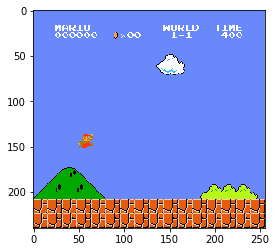

In [47]:
import matplotlib.pyplot as plt 
plt.imshow(h)
plt.show()

In [48]:
print(done)

False


In [49]:
print(reward)

1


In [28]:
import numpy as np 
a,b,c,d = env.step(env.action_space.sample())
model.predict(a.reshape(1,240,256,3))

array([[3.4987988e-05, 7.7925561e-06, 7.5290119e-03, 9.5475543e-01,
        1.6911041e-06, 6.2990716e-06, 1.7567293e-09, 8.4045865e-07,
        1.3829242e-08, 3.6480512e-02, 8.9927134e-06, 1.1744222e-03]],
      dtype=float32)